In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint, 
                                       TensorBoard, Callback)
import datetime
from time import time
import json

import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
physical_devices

tf.config.experimental.set_memory_growth(physical_devices[0], True)
"""
The above line comes from here: 
https://github.com/tensorflow/tensorflow/blob/6e559b96c8146ce15c7c03f66e515e31a6b0aa00/tensorflow/python/framework/config.py#L443
"""

import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv2D, Input, Reshape, 
                                     Lambda, Dense, Conv2DTranspose)

IMG_HEIGHT = 64
IMG_WIDTH  = 64

LATENT_SIZE = 32
BATCH_SIZE  = 128
KL_TOLERANCE = 0.5
LEARNING_RATE = 1e-4

In [2]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    
    # import pdb; pdb.set_trace()
    z_mean, z_log_var = args
    #_batch = z_mean.shape[0]
    #_dim = z_mean.shape[1]
    batch = BATCH_SIZE# if _batch is None else _batch
    dim = LATENT_SIZE #if _dim is None else _dim
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    foo = z_mean + K.exp(0.5 * z_log_var)# * epsilon
    # print(foo.shape)
    bar = foo * epsilon
    # print(bar.shape)
    return bar


## ENCODER

inputs = Input(shape=(64, 64, 3), name='encoder_input')
h = Conv2D(32, 4, strides=2, activation="relu", name="enc_conv1")(inputs)
h = Conv2D(64, 4, strides=2, activation="relu", name="enc_conv2")(h)
h = Conv2D(128, 4, strides=2, activation="relu", name="enc_conv3")(h)
h = Conv2D(256, 4, strides=2, activation="relu", name="enc_conv4")(h)
h = Reshape([2*2*256])(h)
z_mean = Dense(LATENT_SIZE, name='z_mean')(h)
z_log_var = Dense(LATENT_SIZE, name='z_log_var')(h)
z = Lambda(sampling, output_shape=(LATENT_SIZE,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')


encoder.summary()

## DECODER

latent_inputs = Input(shape=(LATENT_SIZE,), name='decoder_input')
h = Dense(4*256, name="dec_fc")(latent_inputs)
h = Reshape([1, 1, 4*256])(h)
h = Conv2DTranspose(128, 5, strides=2, activation="relu", name="dec_deconv1")(h)
h = Conv2DTranspose(64, 5, strides=2, activation="relu", name="dec_deconv2")(h)
h = Conv2DTranspose(32, 6, strides=2, activation="relu", name="dec_deconv3")(h)
outputs = Conv2DTranspose(3, 6, strides=2, activation='sigmoid', name="dec_deconv4")(h)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
enc_conv1 (Conv2D)              (None, 31, 31, 32)   1568        encoder_input[0][0]              
__________________________________________________________________________________________________
enc_conv2 (Conv2D)              (None, 14, 14, 64)   32832       enc_conv1[0][0]                  
__________________________________________________________________________________________________
enc_conv3 (Conv2D)              (None, 6, 6, 128)    131200      enc_conv2[0][0]                  
____________________________________________________________________________________________

In [3]:
def sample(decoder, n=128):
    z = tf.random.normal(shape=(n, LATENT_SIZE))
    return decoder.predict(z)

In [4]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='SpatialWorldModel')

## Loss stuff

# loss
eps = 1e-6 # avoid taking log of zero

# reconstruction loss
r_loss = tf.reduce_sum(
  tf.square(inputs - outputs),
  axis = [1,2,3]
)
r_loss = tf.reduce_mean(r_loss)

# augmented kl loss per dim (axis may need to change)
kl_loss = - 0.5 * tf.reduce_sum(
  (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
  axis = 1
)
# todo: look this up. why did Ha do it this way?
kl_loss = tf.maximum(kl_loss, KL_TOLERANCE * LATENT_SIZE)
kl_loss = tf.reduce_mean(kl_loss)

loss = r_loss + kl_loss

vae.add_loss(loss)
vae.compile(optimizer='adam')

In [6]:
## Small is data fit: can we do well with 5 gigs train, 1 gig val, 1 gig test?

# This way we safely avoid data loaders

data_dir = "./sausage/states/"

#def get_data_dir_size(data_dir):
"""Assuming fixed element size"""
alldata = os.listdir(data_dir)
elem = np.load(os.path.join(data_dir, alldata[0]))
elem_size = elem.__sizeof__()
n_elems = len(alldata)
bytes_to_gigs = 1e-9

total_data_gigs = elem_size * n_elems * bytes_to_gigs
total_data_gigs

18.898944

In [7]:
import random

In [8]:
alldata = os.listdir(data_dir)
#train_frac = 1/18
#alldata = random.sample(alldata, int(np.floor(len(alldata) * train_frac)))

In [9]:
np.random.shuffle(alldata)
test = 1/8

train_ids, test_ids = alldata[int(len(alldata)*test):], alldata[:int(len(alldata)*test)]

def read_data(data_dir, file_IDs):
    t = np.zeros((len(file_IDs), 64, 64, 3), dtype=np.float32)
    for i, file in enumerate(file_IDs):
        t[i] = np.load(os.path.join(data_dir, file))
    return t

In [18]:
!free -m 

OSError: [Errno 12] Cannot allocate memory

In [14]:
train_images = read_data(data_dir, train_ids)

In [ ]:
#test_images = read_data(data_dir, test_ids)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
def myround(x, base=5):
    return int(base * round(float(x)/base))

In [13]:
def myfloor(x, base=128):
    return int(base * int(np.floor(float(x)/base)))

In [15]:
test_size = myround(np.floor(len(train_images) * 1/8), 128)

In [16]:
train, val = train_test_split(train_images, test_size=test_size)

In [17]:
val.shape[0] % 128

0

In [19]:
train_size = myfloor(len(train), 128)

In [20]:
train = train[:train_size]

In [21]:
## Real boii fitting

class TrainTimeCallback(Callback): 
    def __init__(self): 
        super(TrainTimeCallback, self).__init__()
        
    def on_train_begin(self, logs=None): 
        self._start_time = time()
        
    def on_train_end(self, logs=None):
        self._train_time = time() - self._start_time
        
    @property
    def train_time(self):
        s = self._train_time
        hours, remainder = divmod(s, 3600)
        minutes, seconds = divmod(remainder, 60)
        
        return f'{hours:02.0f}:{minutes:02.0f}:{seconds:02.0f}'
    
    def print_train_time(self):
        print(f'Train time for model: {self.train_time}')

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

monitor = 'loss' # change this
callbacks = [
    TrainTimeCallback(),
    ModelCheckpoint('./best_VAE.h5', save_best_only=True, 
                    monitor=monitor),
    EarlyStopping(monitor, patience=10,
                  mode='min',
                  restore_best_weights=True),
    TensorBoard(log_dir=log_dir, histogram_freq=1)
]

In [22]:
!free -m 

OSError: [Errno 12] Cannot allocate memory

In [ ]:
?vae.fit

In [23]:
history = vae.fit(train,
                  epochs=100, 
                  batch_size=BATCH_SIZE,
                  callbacks=callbacks, 
                  validation_data=(val, None), )
    
callbacks[0].print_train_time()

with open('history.json', 'w+') as f:
    f.write(json.dumps(history.history))

Train on 146944 samples, validate on 20992 samples
Epoch 1/100
146944/146944 [==============================] - 73s 499us/sample - loss: 75.8060 - val_loss: 45.3696
Epoch 2/100
146944/146944 [==============================] - 62s 425us/sample - loss: 43.2695 - val_loss: 42.5181
Epoch 3/100
146944/146944 [==============================] - 62s 425us/sample - loss: 40.7751 - val_loss: 40.1590
Epoch 4/100
146944/146944 [==============================] - 63s 427us/sample - loss: 38.9401 - val_loss: 37.8929
Epoch 5/100
146944/146944 [==============================] - 62s 425us/sample - loss: 36.8277 - val_loss: 37.0913
Epoch 6/100
146944/146944 [==============================] - 63s 427us/sample - loss: 35.5287 - val_loss: 35.1801
Epoch 7/100
146944/146944 [==============================] - 63s 427us/sample - loss: 34.7744 - val_loss: 34.6125
Epoch 8/100
146944/146944 [==============================] - 62s 425us/sample - loss: 34.3246 - val_loss: 34.1122
Epoch 9/100
146944/146944 [==========

Epoch 18/100
146944/146944 [==============================] - 63s 427us/sample - loss: 30.6277 - val_loss: 30.9908
Epoch 19/100
146944/146944 [==============================] - 62s 421us/sample - loss: 30.8906 - val_loss: 30.5902
Epoch 20/100
146944/146944 [==============================] - 63s 427us/sample - loss: 30.2521 - val_loss: 30.4160
Epoch 21/100
146944/146944 [==============================] - 62s 421us/sample - loss: 30.2542 - val_loss: 30.4626
Epoch 22/100
146944/146944 [==============================] - 63s 427us/sample - loss: 30.1077 - val_loss: 30.0183
Epoch 23/100
146944/146944 [==============================] - 62s 420us/sample - loss: 30.1576 - val_loss: 29.9564
Epoch 24/100
146944/146944 [==============================] - 63s 427us/sample - loss: 29.7896 - val_loss: 29.6744
Epoch 25/100
146944/146944 [==============================] - 62s 420us/sample - loss: 30.0538 - val_loss: 29.5986
Epoch 26/100
146944/146944 [==============================] - 62s 425us/sample -

146944/146944 [==============================] - 63s 427us/sample - loss: 28.0409 - val_loss: 28.1971
Epoch 47/100
146944/146944 [==============================] - 62s 421us/sample - loss: 28.1594 - val_loss: 28.1110
Epoch 48/100
146944/146944 [==============================] - 63s 429us/sample - loss: 27.9782 - val_loss: 28.0118
Epoch 49/100
146944/146944 [==============================] - 63s 427us/sample - loss: 27.9298 - val_loss: 27.9434
Epoch 50/100
146944/146944 [==============================] - 62s 421us/sample - loss: 27.9725 - val_loss: 28.0747
Epoch 51/100
146944/146944 [==============================] - 62s 421us/sample - loss: 28.0493 - val_loss: 28.0098
Epoch 52/100
146944/146944 [==============================] - 63s 428us/sample - loss: 27.8522 - val_loss: 27.9340
Epoch 53/100
146944/146944 [==============================] - 62s 425us/sample - loss: 27.7071 - val_loss: 27.9572
Epoch 54/100
146944/146944 [==============================] - 62s 420us/sample - loss: 27.913

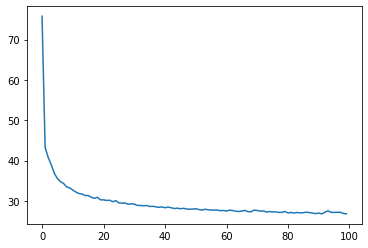

In [24]:
plt.plot(history.history['loss'])

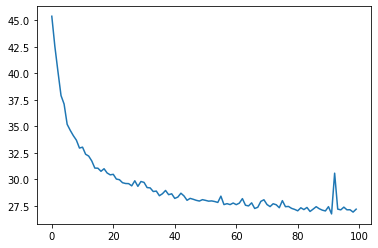

In [25]:
plt.plot(history.history['val_loss'])

In [26]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

In [27]:
im = sample(vae.layers[2])

In [28]:
im.shape

(128, 64, 64, 3)

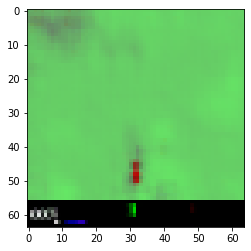

In [33]:
plt.imshow(im[6])

In [43]:
vae.save_weights('./weights/2019.12.07/vae_weights', save_format='tf')

In [44]:
decoder.save_weights('./weights/2019.12.07/decoder_weights', save_format='tf')

In [45]:
encoder.save_weights('./weights/2019.12.07/encoder_weights', save_format='tf')

In [53]:
img = decoder(encoder(train[:128])[2])

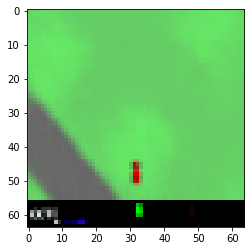

In [54]:
plt.imshow(img[0])

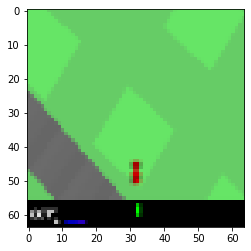

In [55]:
plt.imshow(train[0])